# Qualitative Analysis of Failure Cases

This notebook performs a qualitative inspection of MRI volumes corresponding
to correctly classified subjects and failure cases (false positives and false
negatives).

Visual inspection aims to provide insight into model errors and uncertainty
patterns.

# Imports

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Setup

In [2]:
# Are we running this notebook in colab?
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Personal colab project folder
COLAB_ROOT = Path("/content/drive/MyDrive/Progetti/alzheimer_mri_cnn")

# Ensure working directory is project root
if Path.cwd().parent.name == "alzheimer_mri_cnn":
  os.chdir(Path.cwd().parent)
elif IN_COLAB:
  os.chdir(COLAB_ROOT)
elif Path.cwd().name == "alzheimer_mri_cnn":
  pass
else:
  raise RuntimeError("Project root not found")

print("Working directory set to:", Path.cwd())

# Paths
DB_PATH = Path("./data/processed/oasis.db")
FIGURES_DIR = Path("./outputs/notebooks_figs")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
plt.rcParams["figure.dpi"] = 120

Working directory set to: /content/drive/MyDrive/Progetti/alzheimer_mri_cnn


# Load database

In [3]:
conn = sqlite3.connect(DB_PATH)

query = """
SELECT
    p.patient_id,
    p.label AS true_label,
    pr.predicted_label,
    pr.prob_ad,
    v.path
FROM patients p
JOIN predictions pr USING(patient_id)
JOIN volumes v USING(patient_id)
"""

df = pd.read_sql_query(query, conn)
conn.close()

df.head()


,patient_id,true_label,predicted_label,prob_ad,path
0,OAS1_0011_MR1,0,0,0.005010,data/processed/OAS1_0011_MR1.npy
1,OAS1_0019_MR1,0,0,0.083759,data/processed/OAS1_0019_MR1.npy
2,OAS1_0028_MR1,1,1,0.835283,data/processed/OAS1_0028_MR1.npy
3,OAS1_0035_MR1,1,1,0.833503,data/processed/OAS1_0035_MR1.npy
4,OAS1_0065_MR1,0,0,0.475843,data/processed/OAS1_0065_MR1.npy


# Case separation

In [4]:
true_pos = df[(df.true_label == 1) & (df.predicted_label == 1)]
true_neg = df[(df.true_label == 0) & (df.predicted_label == 0)]
false_pos = df[(df.true_label == 0) & (df.predicted_label == 1)]
false_neg = df[(df.true_label == 1) & (df.predicted_label == 0)]

len(true_pos), len(true_neg), len(false_pos), len(false_neg)


(28, 120, 15, 0)

# Slice based visualization function

In [5]:
def show_slices(volume, title="", cmap="gray"):
    """
    volume shape: (1, D, H, W)
    """
    v = volume[0]
    d, h, w = v.shape

    slices = [
        v[d // 2, :, :],  # sagittal
        v[:, h // 2, :],  # coronal
        v[:, :, w // 2],  # axial
    ]

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for ax, slc in zip(axes, slices):
        ax.imshow(slc.T, cmap=cmap, origin="lower")
        ax.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / f"{title}.png")
    plt.show()


# True positive example

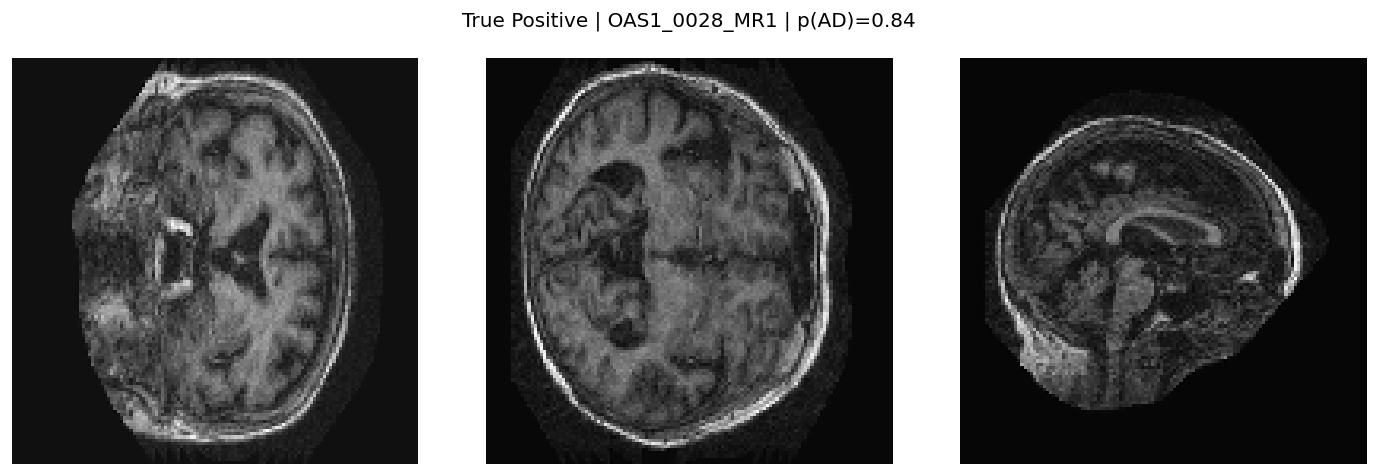

In [6]:
sample = true_pos.iloc[0]

volume = np.load(sample["path"])

show_slices(
    volume,
    title=f"True Positive | {sample.patient_id} | p(AD)={sample.prob_ad:.2f}"
)


# False positive example

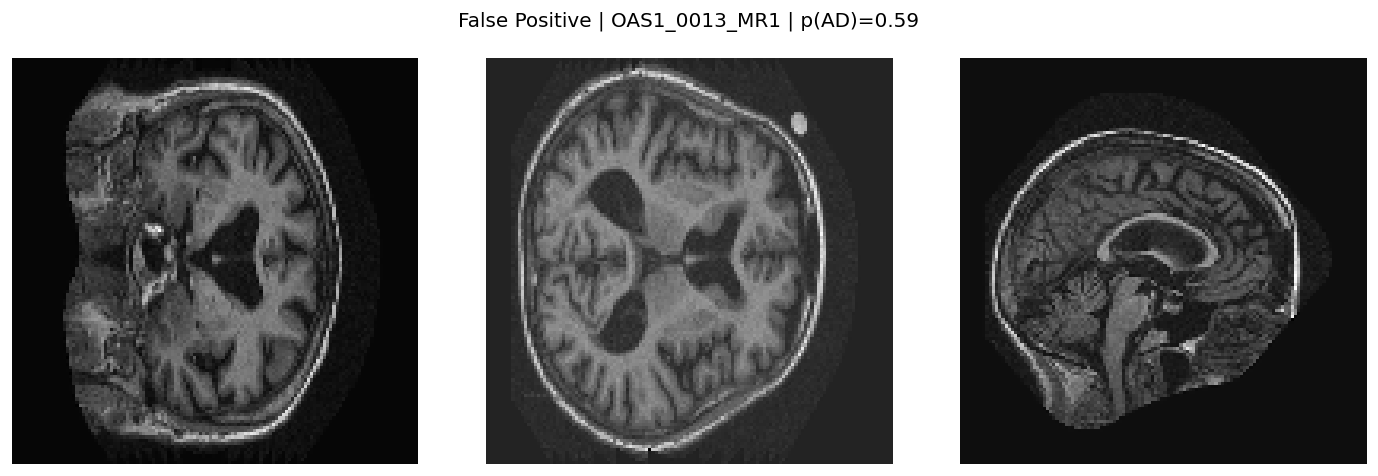

In [7]:
if len(false_pos) > 0:
    sample = false_pos.iloc[0]
    volume = np.load(sample["path"])

    show_slices(
        volume,
        title=f"False Positive | {sample.patient_id} | p(AD)={sample.prob_ad:.2f}"
    )


# True negative example

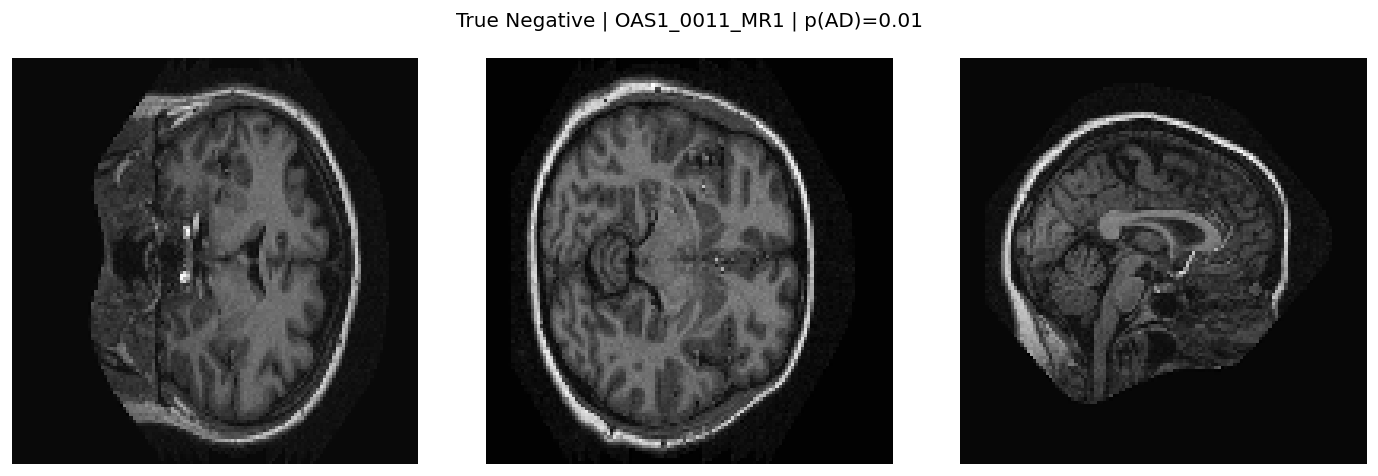

In [8]:
sample = true_neg.iloc[0]

volume = np.load(sample["path"])

show_slices(
    volume,
    title=f"True Negative | {sample.patient_id} | p(AD)={sample.prob_ad:.2f}"
)


# False negative

In [9]:
if len(false_neg) > 0:
    sample = false_neg.iloc[0]
    volume = np.load(sample["path"])

    show_slices(
        volume,
        title=f"False Negative | {sample.patient_id} | p(AD)={sample.prob_ad:.2f}"
    )


# High uncertainty cases from notebook 2

In [10]:
df["uncertainty"] = np.abs(df["prob_ad"] - 0.5)
ambiguous = df.sort_values("uncertainty").head(3) # Only first 3 cases
ambiguous


,patient_id,true_label,predicted_label,prob_ad,path,uncertainty
71,OAS1_0113_MR1,0,0,0.496564,data/processed/OAS1_0113_MR1.npy,0.003436
51,OAS1_0221_MR1,0,1,0.518897,data/processed/OAS1_0221_MR1.npy,0.018897
12,OAS1_0116_MR1,0,0,0.476667,data/processed/OAS1_0116_MR1.npy,0.023333


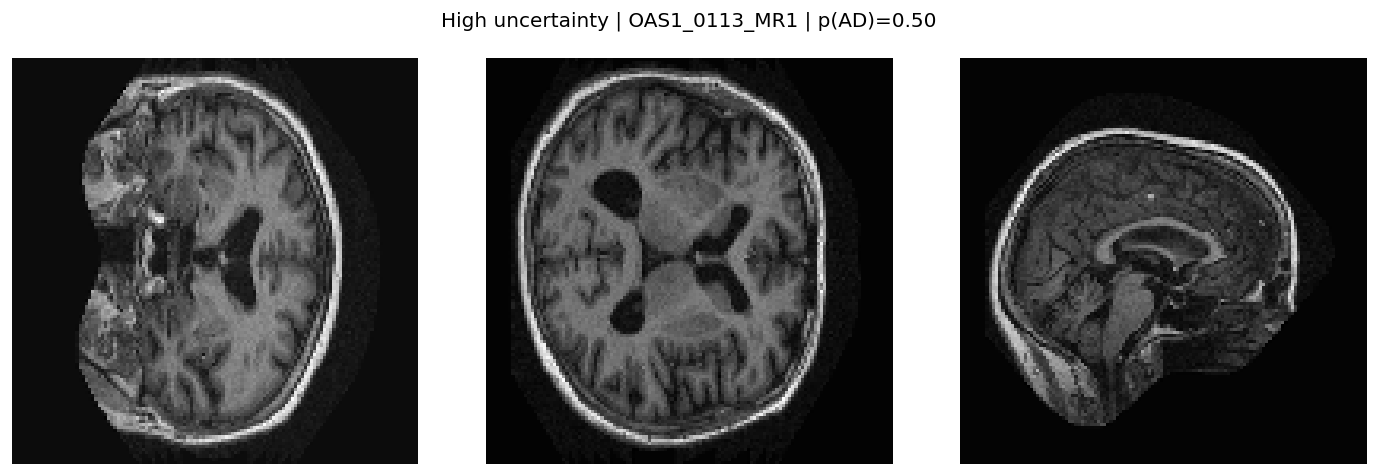

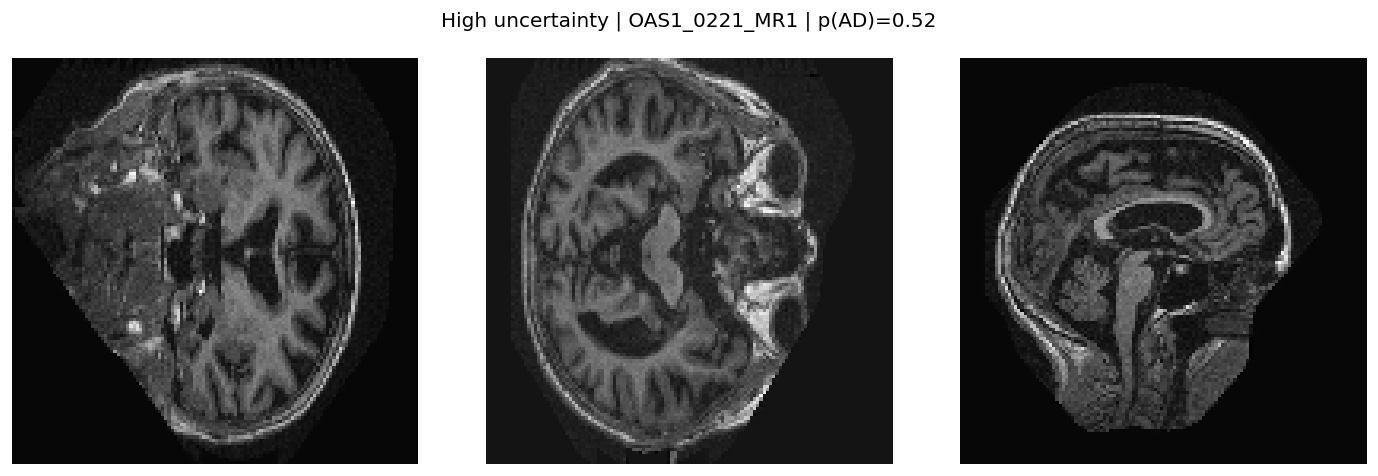

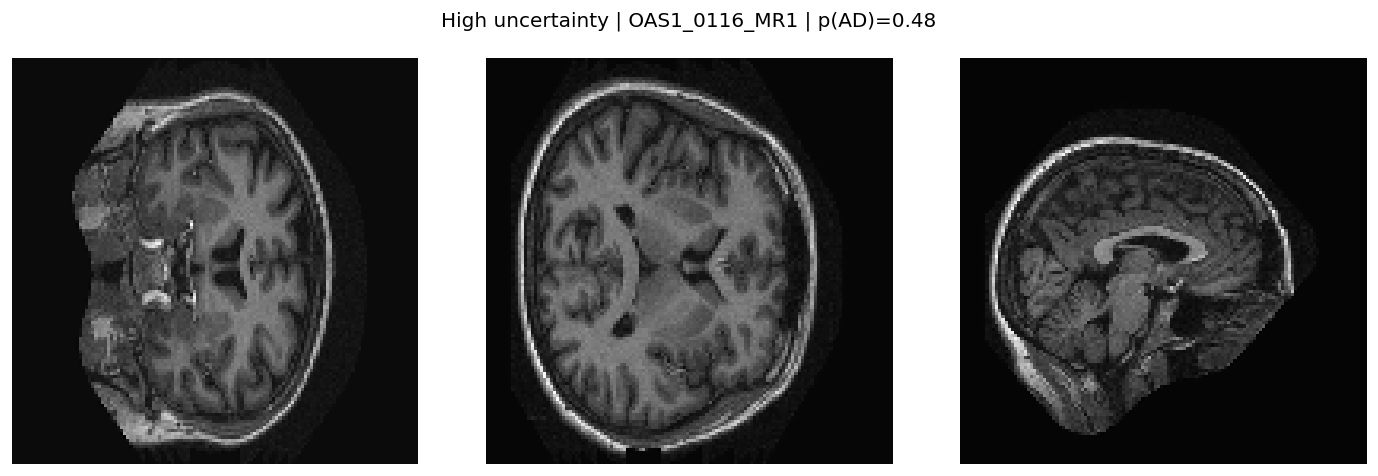

In [11]:
for _, row in ambiguous.iterrows():
    volume = np.load(row["path"])
    show_slices(
        volume,
        title=f"High uncertainty | {row.patient_id} | p(AD)={row.prob_ad:.2f}"
    )
